# Note 

In this chapter, `np.random` is not used except for `np.random.rand()`. <br>
In `prml.sampling_methods`, this princple is followed.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import gamma 
from scipy.stats import gamma as gamma_dense 

# Inverse Sampling

In [15]:
class InverseFunctionSampling():
    def __init__(self,inv_f,a=0,b=1):
        self.inv_f = inv_f
        self.w = b - a  
        self.c = a 

    def sampling(self, n=100):
        z = np.random.rand(n)*self.w + self.c
        return self.inv_f(z)

In [4]:
def p(x,lamda = 1):
    return lamda*np.exp(-lamda*x)

def inv_f(x,lamda=1):
    return -np.log(1 - x)/lamda

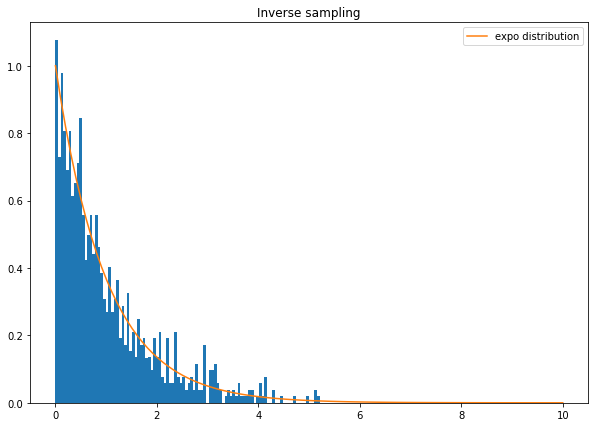

In [5]:
sampler = InverseFunctionSampling(inv_f)
X = sampler.sampling(n = 1000)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(X,bins=100,density=True,stacked=True) # for normalize 
x = np.linspace(0,10,100)
ax.plot(x,p(x),label="expo distribution")
ax.set_title("Inverse sampling")
plt.legend()
plt.show()

# Box Muller

In [6]:
class BoxMuller():
    def __init__(self):
        pass 
    def sampling(self,n = 100):
        # circle 
        Z = np.random.rand(n,2) 
        Z = 2*Z - 1 
        Z = Z[Z[:,0]**2 + Z[:,1]**2 <= 1]

        r2 = Z[:,0]**2 + Z[:,1]**2 
        norm = (-2*np.log(r2)/r2)**0.5
        Y = (norm*Z.T).ravel()

        # adjust number of data
        if len(Y) < n:
            data = self.sampling(n=n-len(Y))
            return np.concatenate((Y,data))
        else:
            return Y[:n]

In [7]:
def gauss(x):
    return 1/(2*np.pi)**0.5*np.exp(-x**2/2)

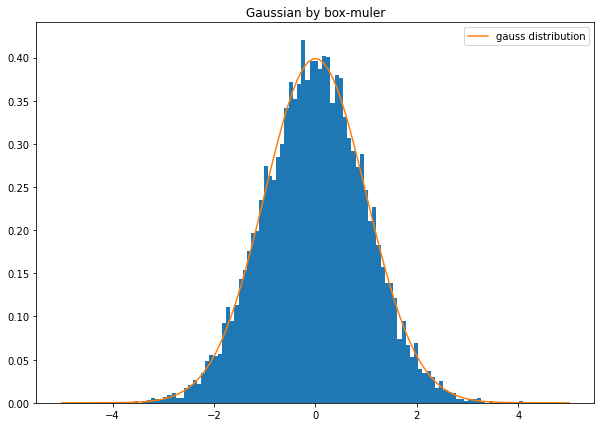

In [8]:
bm = BoxMuller()
X = bm.sampling(n=10000)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(X,bins=100,density=True,stacked=True) # for normalize 
x = np.linspace(-5,5,100)
ax.plot(x,gauss(x),label="gauss distribution")
ax.set_title("Gaussian by box-muler")
plt.legend()
plt.show()

## Gauss sampling

In [9]:
class GaussSampling():
    """GaussSampling

    if D = 1 you shoule use BoxMuller instead 

    """
    def __init__(self,D=1,mu=None,sigma=None):
        self.D = D
        self.gauss_sampler = BoxMuller()
        if mu is None:
            self.mu = np.zeros(D)
        else:
            if mu.shape[0] != D:
                raise ValueError("mu.shape[0] should be equal to D")
            else:
                self.mu = mu

        if sigma is None:
            sigma = np.eye(D)
        elif sigma.shape[0] != D:
            raise ValueError("sigma.shape[0] should be equal to D")
        
        self.L = np.linalg.cholesky(sigma)
    
    def sampling(self,n=100):
        data = self.gauss_sampler.sampling(n = n*self.D) 
        data = data.reshape(n,self.D)
        return self.mu + np.dot(self.L,data.T).T

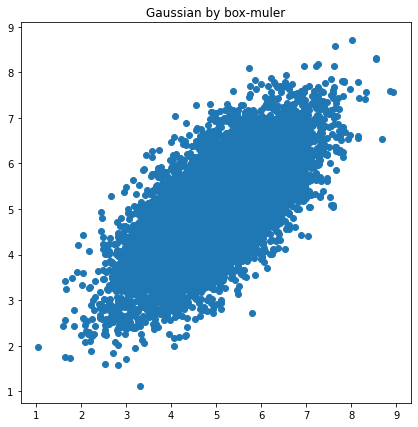

In [10]:
smp = GaussSampling(D = 2,mu = np.array([5,5]),sigma=np.array([[1,0.7],[0.7,1]]))
X = smp.sampling(n = 10000)

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(X[:,0],X[:,1])
ax.set_title("Gaussian by box-muler")
plt.show()

# Rejection Sampling

In [11]:
class RejectionSampling():
    """Rejection Sampling 

    1D ramdom variable sampler

    """
    def __init__(self,p,q,q_sampler,k=None,k_lower=None,k_upper=None):
        self.p = p 
        self.q = q
        self.q_sampler = q_sampler 
        
        if k is None:
            self.k = self._find_appropriate_k(k_lower,k_upper)
        else:
            self.k = k
    
    def _find_appropriate_k(self,k_lower,k_upper):
        k_lower = -100 if k_lower is None else k_lower
        k_upper = 100 if k_upper is None else k_upper 
        k = -1e20
        for x in np.linspace(k_lower,k_upper,500):
            qx = self.q(x)
            px = self.p(x)
            qx = 1e-10 if qx==0.0 else qx
            now_k = px/qx + 1e-5
            k = max(k,now_k)
        return k      

    def sampling(self,n=100):
        sample_n = int(1.5*n)
        z = self.q_sampler.sampling(sample_n)
        u = np.random.rand(sample_n)*self.k*self.q(z)
        is_valid = u <= self.p(z)
        valid_size = is_valid.astype("int").sum()
        data = z[is_valid]
        if valid_size < n:
            additive_data = self.sampling(n=n-valid_size)
            return np.concatenate((data,additive_data))
        else:
            return data[:n]

In [12]:
def p_unnormalized(x,a=2,b=2):
    # gamma without norm const
    return x**(a-1)*np.exp(-b*x)

def p(x,a=2,b=2):
    # gamma with norm const
    return gamma_dense.pdf(x,a=a,scale=1/b)

def q(x,b=1,c=0):
    # cauchy 
    return 1/(1 + (x - c)**2/b**2)

def inv_f(x,b=1,c=0):
    # cauchy 
    return b*np.tan(x) + c

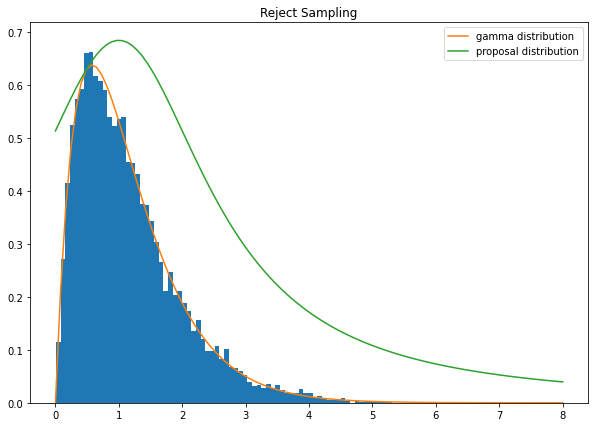

In [16]:
a = 2 
b = (2*a-1)**0.5
c = a-1

isp = InverseFunctionSampling(
    inv_f=lambda x:inv_f(x,b,c),
    a=-np.pi/2,
    b=np.pi/2
)
rsp = RejectionSampling(
    p=lambda x:p(x,a,b),
    q=lambda x:q(x,b,c),
    q_sampler=isp,
    k_lower=0,
    k_upper=10
)
X = rsp.sampling(n=10000)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(X,bins=100,density=True,stacked=True) # for normalize 
x = np.linspace(0,8,100)
ax.plot(x,p(x,a,b),label="gamma distribution")
ax.plot(x,rsp.k*q(x,b,c),label="proposal distribution")
ax.set_title("Reject Sampling")
plt.legend()
plt.show()

# Importance Sampling

In [17]:
class ImportanceSampling():
    def __init__(self,p,f,q=None,q_sampler=None):
        self.p = p 
        self.f = f 
        if q is None:
            self.q = lambda x:1/(2*np.pi)**0.5*np.exp(-0.5*x**2)
            self.q_sampler = GaussSampling() 
        else:
            self.q = q 
            self.q_sampler = q_sampler

    def calc_expectation(self,n=100):
        x = self.q_sampler.sampling(n=n)
        r = self.p(x)/self.q(x)
        f = self.f(x)
        r /= r.sum() 
        return np.dot(r,f) 

In [18]:
a = 2 
b = (2*a-1)**0.5
c = a-1

isp = InverseFunctionSampling(
    inv_f=lambda x:inv_f(x,b,c),
    a=-np.pi/2,
    b=np.pi/2
)
imsp = ImportanceSampling(
    p=lambda x:p(x,a,b),
    f=lambda x:x,
    q=lambda x:q(x,b,c),
    q_sampler=isp
)
Ex = imsp.calc_expectation(n=10000) 
print("calculated E[x] ",Ex)
print("true E[x] ",a/b)

calculated E[x]  1.1391963859395116
true E[x]  1.1547005383792517


# SIR

In [19]:
class SIR():
    def __init__(self,p,q=None,q_sampler=None):
        self.p = p 
        if q is None:
            self.q = lambda x:1/(2*np.pi)**0.5*np.exp(-0.5*x**2)
            self.q_sampler = GaussSampling() 
        else:
            self.q = q 
            self.q_sampler = q_sampler
    
    def sampling(self,n=100):
        x = self.q_sampler.sampling(n=n)
        r = self.p(x)/self.q(x)
        r /= r.sum() 

        # these code can be  replaced by np.random.multinomial(n,r) 
        w_cumsum = np.cumsum(r) 
        rv = np.random.rand(n) - 1e-20 # prevent chose_idx from goin to n
        chose_idx = np.searchsorted(w_cumsum,rv) 
        return x[chose_idx]

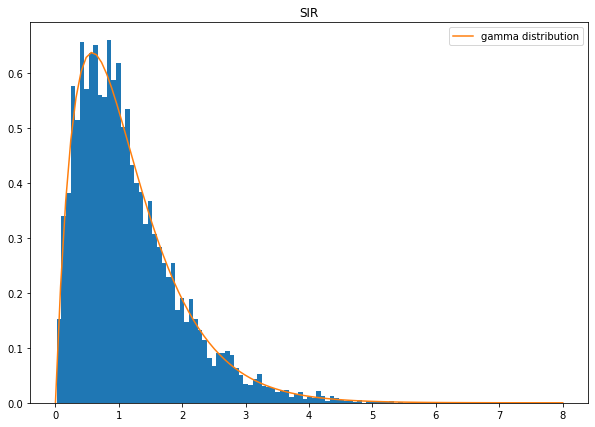

In [20]:
a = 2 
b = (2*a-1)**0.5
c = a-1

isp = InverseFunctionSampling(
    inv_f=lambda x:inv_f(x,b,c),
    a=-np.pi/2,
    b=np.pi/2
)
sir = SIR(
    p=lambda x:p(x,a,b),
    q=lambda x:q(x,b,c),
    q_sampler=isp
)
X = sir.sampling(n=10000)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(X,bins=100,density=True,stacked=True) # for normalize 
x = np.linspace(0,8,100)
ax.plot(x,p(x,a,b),label="gamma distribution")
ax.set_title("SIR")
plt.legend()
plt.show()

# Metropolis Hastings 

In [22]:
class MetropolisHastingsSampling():
    def __init__(self,p,D,q=None,q_sampler=None,symm=False,first_discard=0.2):
        self.p = p 
        self.D = D
        if q is None:
            self.q = lambda z,z_cond:1/(2*np.pi)**(D/2)*np.exp(-0.5*np.sum((z-z_cond)**2))
            self.q_sampler = GaussSampling(D = D)
            symm = True 
        else:
            self.q = q 
            self.q_sampler = q_sampler
        self.symm = symm
        self.first_discard = first_discard
    
    def _is_accept(self,z,z_next):
        if self.symm:
            accept_prob = self.p(z_next)/self.p(z)
        else:
            accept_prob = self.p(z_next)*self.q(z,z_next)/(self.p(z)*self.q(z_next,z))
        a = np.random.rand()
        return a <= accept_prob

    def sampling(self,n=100):
        m = int(n/(1 - self.first_discard) + 5) # neccesay data size
        d_size = 0
        data = np.zeros((m,self.D))
        z = np.random.rand(self.D)
        while d_size < m:
            z_next = self.q_sampler.sampling(n=1)[0] + z
            if self._is_accept(z,z_next):
                data[d_size] = z_next.copy()
                z = z_next
                d_size += 1
        return data[-n:]    

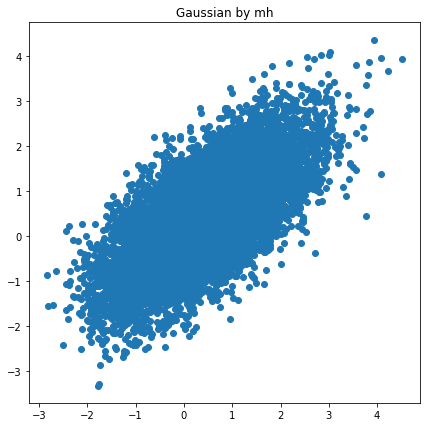

In [23]:
mu = np.array([0.5,0.5])
sigma = np.array([[1.0,0.7],[0.7,1]])
sigma_inv = np.linalg.inv(sigma)
de = np.linalg.det(sigma)
def p(x):
    return 1/(4*np.pi**2*de)**0.5*np.exp(-0.5*np.dot(x-mu,sigma_inv@(x-mu).reshape(-1,1)))

mh = MetropolisHastingsSampling(p,2,symm=True)
X = mh.sampling(n=10000)

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(X[:,0],X[:,1])
ax.set_title("Gaussian by mh")
plt.show()